# Chicago Crime Data
- Source: Chicago Data Portal: Crimes 2001 to Present
  - Data Description:
  - All Crimes that were reported in the city of Chicago and their details

Includes:
- type of crime, exact date/time, lat/long, District/ward, was there an arrest, etc.
  - Note: the .csv is very large and needs to be processed into smaller files to fit inside a GitHub repository. We have provided a helper notebook below to process your downloaded file into a repo-friendly format.
- Data Processing Helper Notebook:
  - Use the helper notebook in this repository to process your manually-downloaded csv into several .csv.gz files: https://github.com/coding-dojo-data-science/preparing-chicago-crime-data
  - You can either Fork your own copy of the repository and rename it to be your "Project 4" repository, or you can download the notebook and save it in your own repository.
- Supplemental Data: Holiday Data
  - To answer some of the possible questions, you may need to perform some feature engineering, like adding holiday information from an API.
  - We have provided an extract of holidays, but you may wish to extract additional holiday information for dates not included in this file.

    - Raw CSV URL (Pandas): https://docs.google.com/spreadsheets/d/e/2PACX-1vTMR4vi1nFtbYO_WLqecU6WoRAQ0F-_QCMcuWUoZhuTygAP2U668cddCWBeAV2eop9fFdyXX856AB2j/pub?output=csv
- Notes/Considerations:
  - You may need to keep 2 forms of the data:
  - The original individual crime data with a datetime index. (Each row is 1 crime)
  - A resampled/converted crime counts version (Each row is 1 day)

## Task
Our task is to answer a series of questions about trends in crimes in Chicago for a reporter for the local newspaper.

- Stakeholder Questions to Answer (pick at least 3 topics) Select 3 or more of the following topics to analyze:
1). Comparing Police Districts:
  - Which district has the most crimes? Which has the least?
  
2). Crimes Across the Years:
  - Is the total number of crimes increasing or decreasing across the years?
  - Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?
  
3). Comparing AM vs. PM Rush Hour:
  - Are crimes more common during AM rush hour or PM rush hour?
    - You can consider any crime that occurred between 7 AM - 10 AM as AM rush hour
    - You can consider any crime that occurred between 4 -7 PM as PM rush hour.
  - What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
  - Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?
  
4). Comparing Months:
 - What months have the most crime? What months have the least?
 - Are there any individual crimes that do not follow this pattern? If so, which crimes?
 
5). Comparing Holidays:
  - Are there any holidays that show an increase in the # of crimes?
  - Are there any holidays that show a decrease in the # of crimes?

# DataFrames

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
# Using Crime files from 2012 for these questions
df_2012  = pd.read_csv("Data/Chicago/Chicago-Crime_2012.csv", low_memory=False)

In [3]:
df_2012 = df_2012.astype({'District':'int64'})
df_2012.drop(columns=['ID', 'Beat', 'Latitude', 'Longitude', 'Ward'], inplace = True)

In [4]:
df_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336259 entries, 0 to 336258
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Date                  336259 non-null  object
 1   Primary Type          336259 non-null  object
 2   Description           336259 non-null  object
 3   Location Description  335803 non-null  object
 4   Arrest                336259 non-null  bool  
 5   Domestic              336259 non-null  bool  
 6   District              336259 non-null  int64 
dtypes: bool(2), int64(1), object(4)
memory usage: 13.5+ MB


In [57]:
df_2012['Primary Type'].value_counts()

THEFT                               75466
BATTERY                             59135
CRIMINAL DAMAGE                     35855
NARCOTICS                           35489
BURGLARY                            22845
ASSAULT                             19899
OTHER OFFENSE                       17483
MOTOR VEHICLE THEFT                 16492
DECEPTIVE PRACTICE                  13756
ROBBERY                             13485
CRIMINAL TRESPASS                    8216
WEAPONS VIOLATION                    3907
PUBLIC PEACE VIOLATION               3007
OFFENSE INVOLVING CHILDREN           2312
PROSTITUTION                         2204
CRIMINAL SEXUAL ASSAULT              1457
INTERFERENCE WITH PUBLIC OFFICER     1228
SEX OFFENSE                          1087
GAMBLING                              724
LIQUOR LAW VIOLATION                  573
HOMICIDE                              515
ARSON                                 469
KIDNAPPING                            235
STALKING                          

In [6]:
# Cleaning up some of the data
df_2012['Primary Type'] = df_2012['Primary Type'].replace('CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT')
df_2012['Primary Type'] = df_2012['Primary Type'].replace('NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)')

In [7]:
## convert datetime to datetime
df_2012['Datetime'] = pd.to_datetime(df_2012['Date'])

In [8]:
df_2012 = df_2012.set_index('Datetime')
df_2012.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,District
Datetime,,,,,,,
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,APARTMENT,True,False,10
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,STREET,False,False,1
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,BATTERY,AGGRAVATED: OTHER DANG WEAPON,STREET,False,False,10
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,4
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,BURGLARY,HOME INVASION,APARTMENT,False,False,4


In [9]:

# get list of  unique crime descriptions
crime_list = df_2012['Primary Type'].unique()
CRIMES = {}

for crime in crime_list:
    
   temp = df_2012.loc[ df_2012['Primary Type']==crime].copy()
    
   temp_res = temp.resample("M").size() 
   
   CRIMES[crime] = temp_res.copy() 

In [10]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df

,SEX OFFENSE,CRIMINAL SEXUAL ASSAULT,BATTERY,OFFENSE INVOLVING CHILDREN,BURGLARY,THEFT,OTHER OFFENSE,ROBBERY,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,...,PROSTITUTION,HOMICIDE,STALKING,KIDNAPPING,GAMBLING,INTIMIDATION,PUBLIC INDECENCY,OBSCENITY,NON-CRIMINAL (SUBJECT SPECIFIED),OTHER NARCOTIC VIOLATION
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-31,144,132,4309,270,1757,5713,1538,1011,2660,1144,...,194,43,24,17,9,10,2.0,4,NaN,NaN
2012-02-29,64,103,3960,168,1398,4887,1548,696,2350,1012,...,198,28,17,14,17,11,1.0,1,NaN,NaN
2012-03-31,112,107,5276,216,1638,5938,1490,845,3144,1087,...,267,53,20,15,44,13,0.0,3,NaN,NaN
2012-04-30,76,111,4695,153,1646,6192,1467,975,3081,1086,...,173,41,15,23,62,15,0.0,2,NaN,NaN
2012-05-31,104,132,5839,192,1924,6463,1531,1267,3271,1089,...,135,50,13,20,65,17,2.0,3,2.0,NaN
2012-06-30,113,134,5805,213,2063,7072,1494,1282,3502,1109,...,210,49,16,21,107,7,1.0,0,0.0,NaN
2012-07-31,98,154,5971,211,2277,7263,1515,1332,3424,1131,...,209,50,18,21,103,17,5.0,0,3.0,NaN
2012-08-31,85,132,5376,184,2221,7027,1469,1272,3092,1225,...,198,56,15,21,127,11,1.0,2,1.0,2.0
2012-09-30,92,108,4761,159,1993,6562,1337,1168,2956,1120,...,174,44,13,25,86,18,2.0,3,1.0,1.0


# Topic 1
 Comparing Months:

- What months have the most crime? What months have the least?
- Are there any individual crimes that do not follow this pattern? If so, which crimes?

In [11]:
# Add a count column with a value of 1 for each row and then use reasmple().sum()
ts = df_2012.copy()
ts['Count'] = 1
ts

,Date,Primary Type,Description,Location Description,Arrest,Domestic,District,Count
Datetime,,,,,,,,
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,APARTMENT,True,False,10,1
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,STREET,False,False,1,1
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,BATTERY,AGGRAVATED: OTHER DANG WEAPON,STREET,False,False,10,1
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,4,1
2012-01-01 01:00:00,01/01/2012 01:00:00 AM,BURGLARY,HOME INVASION,APARTMENT,False,False,4,1
...,...,...,...,...,...,...,...,...
2012-12-31 00:50:00,12/31/2012 12:50:00 AM,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,10,1
2012-12-31 12:50:00,12/31/2012 12:50:00 PM,CRIMINAL DAMAGE,TO PROPERTY,BARBERSHOP,False,False,4,1
2012-12-31 00:50:00,12/31/2012 12:50:00 AM,THEFT,$500 AND UNDER,SIDEWALK,False,False,17,1


In [12]:
# Resample the data as Monthly frequency.
ts_M = ts.resample("M").size()
ts_M

Datetime
2012-01-31    26323
2012-02-29    23885
2012-03-31    28573
2012-04-30    27189
2012-05-31    30111
2012-06-30    31096
2012-07-31    31987
2012-08-31    30053
2012-09-30    27772
2012-10-31    27984
2012-11-30    26044
2012-12-31    25242
Freq: M, dtype: int64

In [13]:
# Find the date and corresponding value for the max precipitation.
date_most_crime = ts_M.idxmax()
date_most_crime

Timestamp('2012-07-31 00:00:00', freq='M')

In [14]:
# Max Precipitation
max_crime = ts_M.loc[ date_most_crime]
max_crime

31987

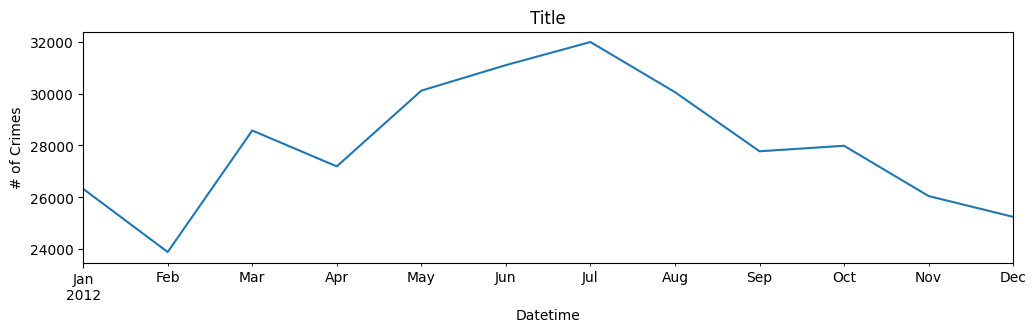

In [15]:
fig, ax = plt.subplots(figsize=(12,3))
ts_M.plot(ax=ax)
ax.set(title='Title', ylabel='# of Crimes', xlabel='Datetime')

# customize major ticks 
major_loc =  mdates.YearLocator(1)
major_fmt = mdates.DateFormatter("%M")

# customize minor ticks
minor_loc =  mdates.MonthLocator(interval=3)

## Final xdate tweaks
fig = ax.get_figure()

## July had the most crime reported while February had the least.

In [16]:
crimes_ts = crimes_df.copy()

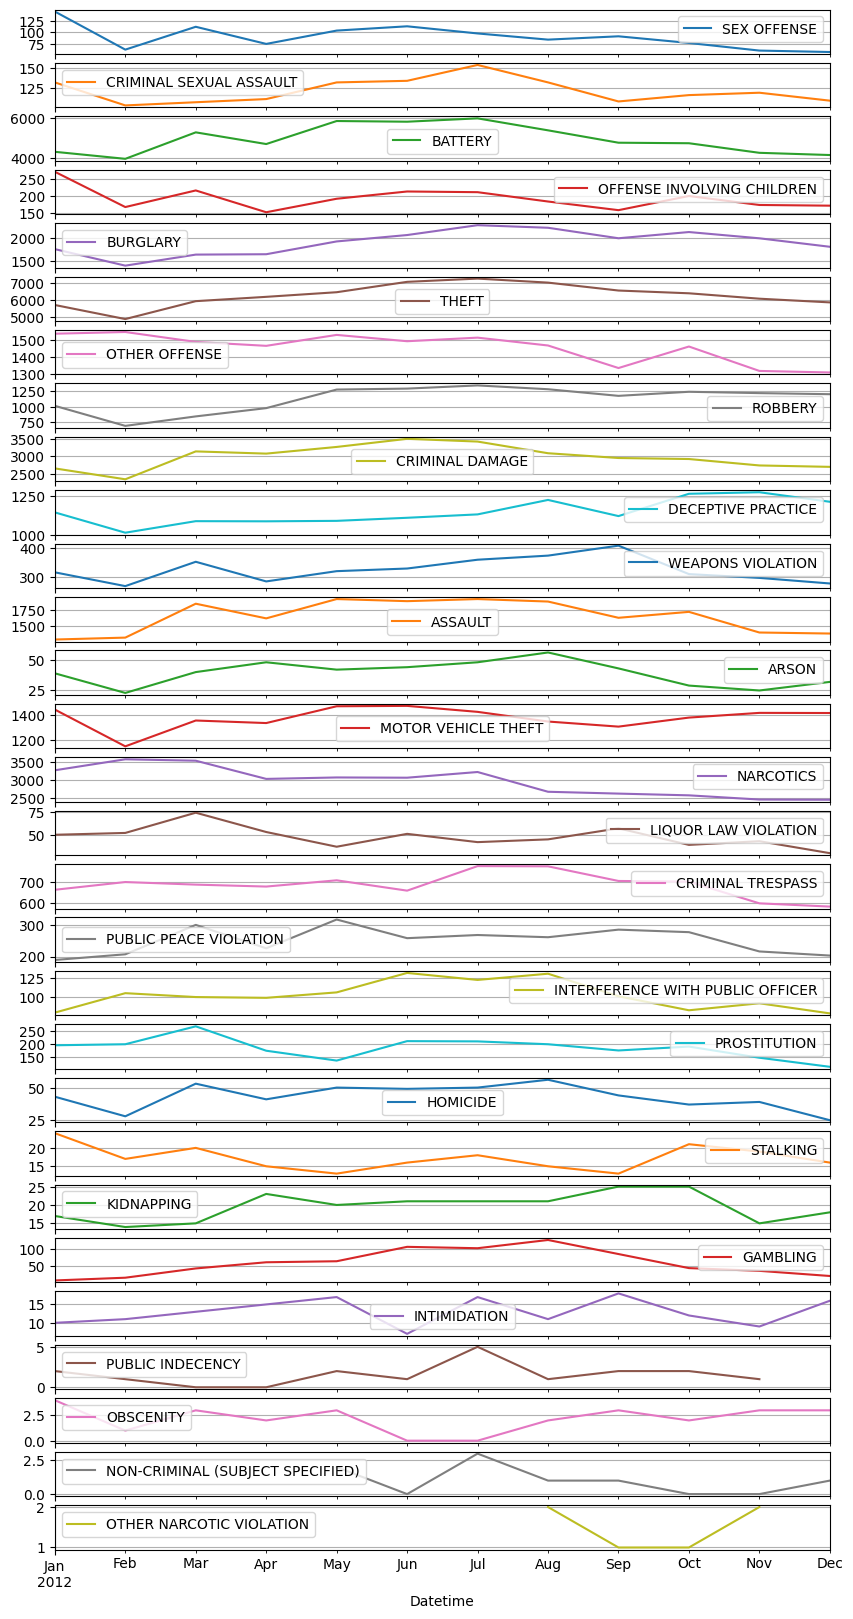

In [17]:
crimes_ts.plot(subplots=True,figsize=(10,20),grid=True);

### Comparing Months:
- Several crimes seemed to follow this pattern, including criminal damage, public indecency, intimidation, etc.

# Topic 2:
Comparing AM vs. PM Rush Hour:

- Are crimes more common during AM rush hour or PM rush hour?
- You can consider any crime that occurred between 7 AM - 10 AM as AM rush hour
- You can consider any crime that occurred between 4 -7 PM as PM rush hour.
- What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
- Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?

In [18]:
# adding hour of the day (12am=0) 
df_2012['HourOfDay'] = df_2012.index.hour 

In [19]:
## Get # of crimes by Hour
crimes_by_hour = df_2012.groupby('Primary Type')['HourOfDay'].value_counts().sort_index()
crimes_by_hour

Primary Type       HourOfDay
ARSON              0             40
                   1             33
                   2             47
                   3             46
                   4             30
                               ... 
WEAPONS VIOLATION  19           319
                   20           312
                   21           312
                   22           370
                   23           295
Name: HourOfDay, Length: 622, dtype: int64

In [20]:
## convert to dataframe and reset_index()
plot_df = crimes_by_hour.to_frame('# of Crimes').reset_index()
plot_df

,Primary Type,HourOfDay,# of Crimes
0,ARSON,0,40
1,ARSON,1,33
2,ARSON,2,47
3,ARSON,3,46
4,ARSON,4,30
...,...,...,...
617,WEAPONS VIOLATION,19,319
618,WEAPONS VIOLATION,20,312
619,WEAPONS VIOLATION,21,312
620,WEAPONS VIOLATION,22,370


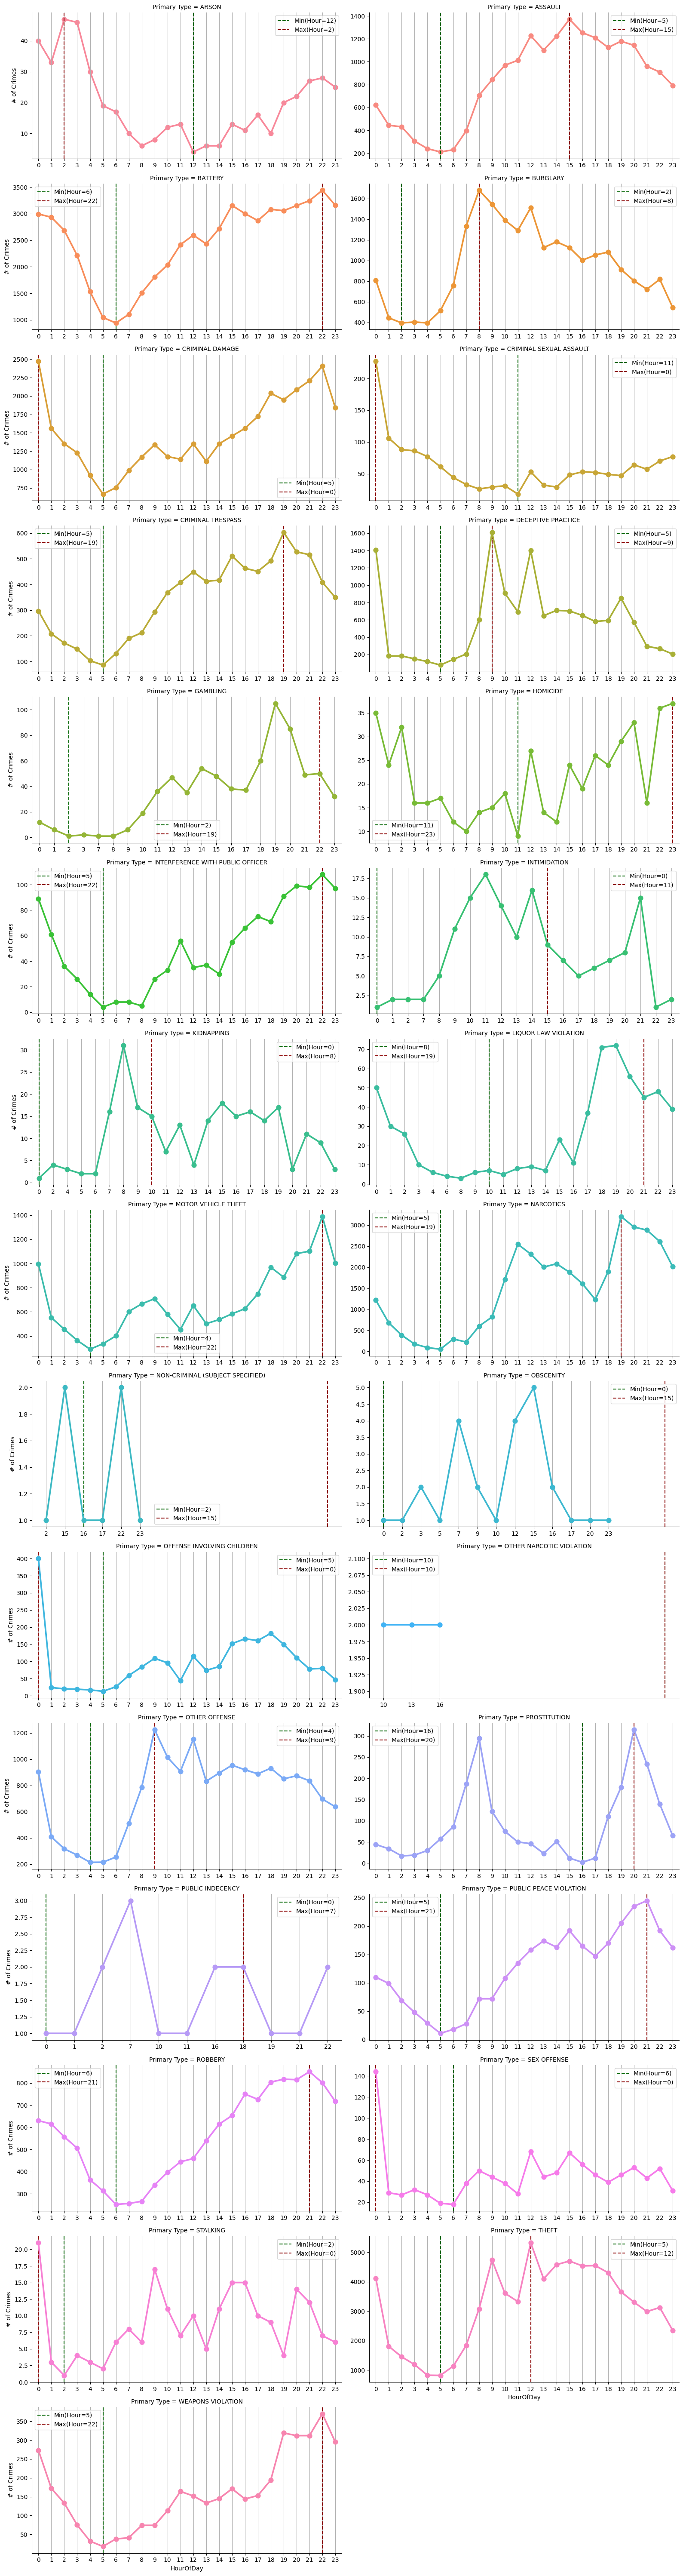

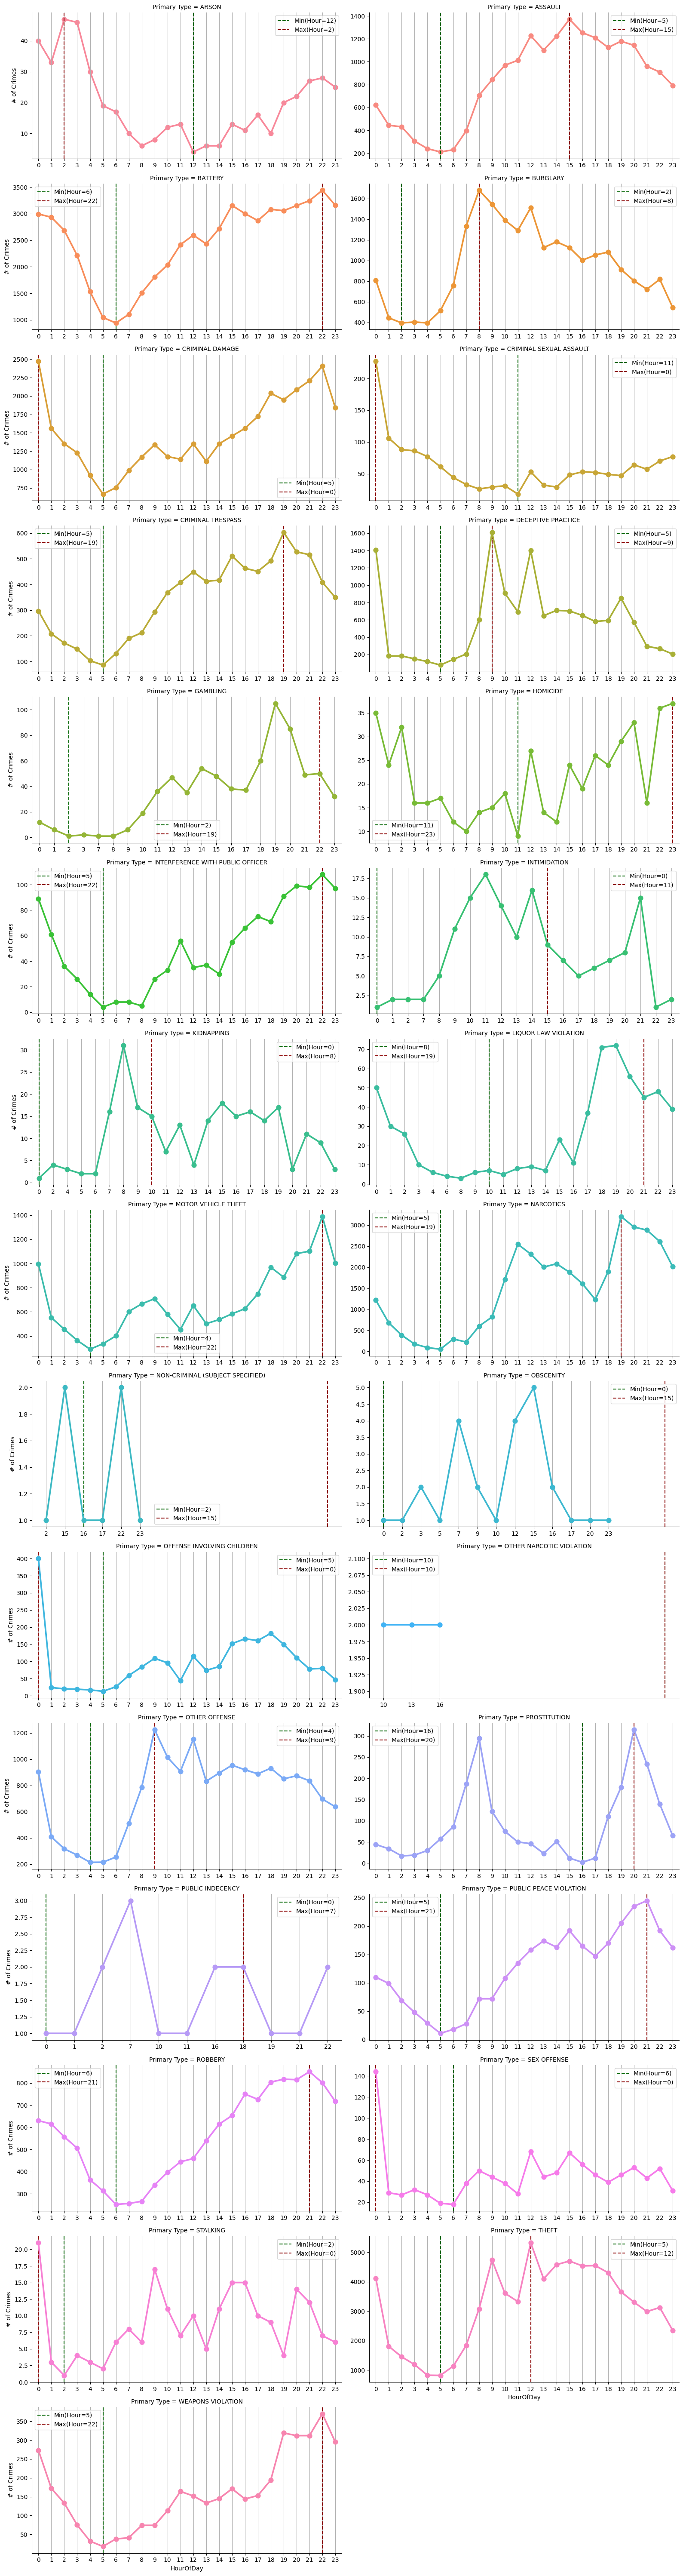

In [21]:
g = sns.catplot(data=plot_df, x='HourOfDay', y='# of Crimes',
                hue='Primary Type', col='Primary Type',col_wrap=2,
            aspect=2, height=4,
           kind='point',sharey=False,sharex=False);
## loop throught the axes dict
for col, ax in g.axes_dict.items():
    
    ## Extract the idx min and idxmax from the val counts
    min_, max_ = crimes_by_hour.loc[col].agg(['idxmin','idxmax'])
    
    ## add vlines for both and SAVE THE LINE and a label to use in legend
    ln1 = ax.axvline(min_, color='darkgreen',ls='--')
    lab1 = f'Min(Hour={min_})'
    
    ln2 = ax.axvline(max_,color='darkred',ls='--')
    lab2 = f'Max(Hour={max_})'
    
    ## manually add legend using list of ln1 and ln2 and a list of labels
    ax.legend( [ln1,ln2], [lab1,lab2] )
    ## add x grid
    ax.grid(axis='x')
    
g.fig

In [22]:
crimes_by_hour2 = df_2012.groupby('HourOfDay')['Primary Type'].value_counts().sort_index()
crimes_by_hour2

HourOfDay  Primary Type     
0          ARSON                  40
           ASSAULT               621
           BATTERY              2995
           BURGLARY              809
           CRIMINAL DAMAGE      2472
                                ... 
23         ROBBERY               717
           SEX OFFENSE            31
           STALKING                6
           THEFT                2351
           WEAPONS VIOLATION     295
Name: Primary Type, Length: 622, dtype: int64

In [23]:
AM_crimes = crimes_by_hour2.loc[7:10]
AM_crimes

HourOfDay  Primary Type     
7          ARSON                  10
           ASSAULT               395
           BATTERY              1105
           BURGLARY             1334
           CRIMINAL DAMAGE       988
                                ... 
10         ROBBERY               397
           SEX OFFENSE            38
           STALKING               11
           THEFT                3609
           WEAPONS VIOLATION     113
Name: Primary Type, Length: 105, dtype: int64

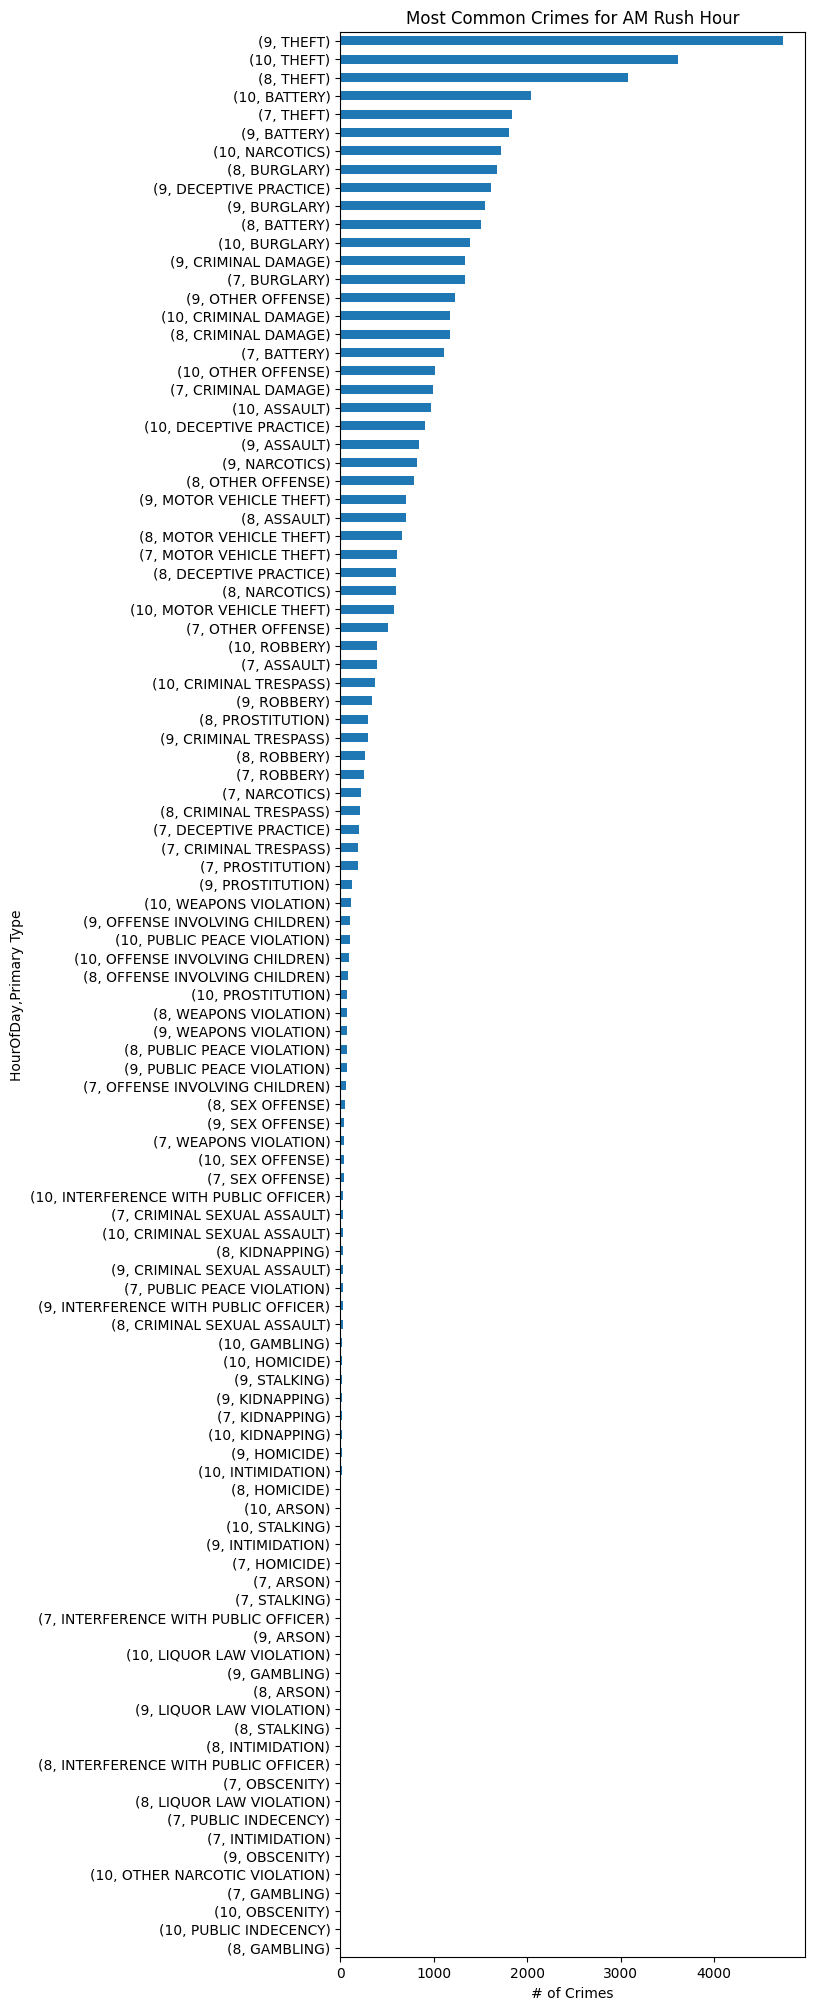

In [24]:
ax = AM_crimes.sort_values().plot(kind='barh',figsize=(6,25))
ax.set(title='Most Common Crimes for AM Rush Hour',xlabel='# of Crimes');

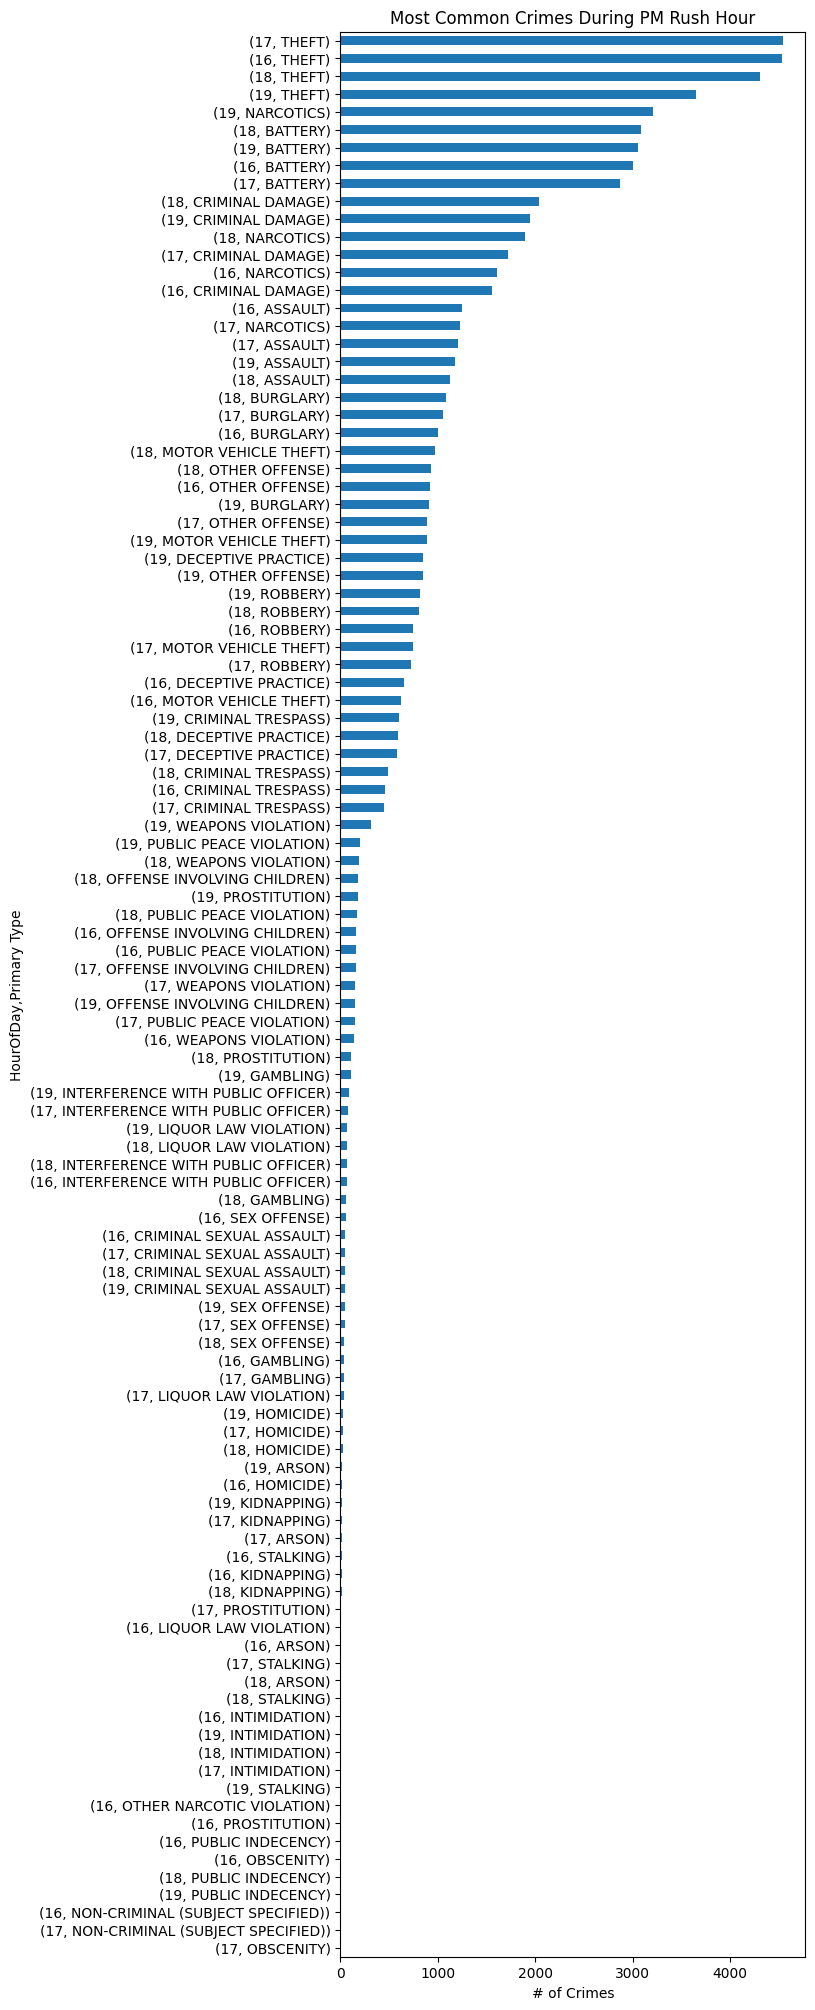

In [25]:
PM_crimes = crimes_by_hour2.loc[16:19]
#Plot PM Crimes
ax = PM_crimes.sort_values().plot(kind='barh',figsize=(6,25))
ax.set(title='Most Common Crimes During PM Rush Hour',xlabel='# of Crimes');

### Comparing AM vs. PM Rush Hour:
- Are crimes more common during AM rush hour or PM rush hour?

   - I would say majority of crimes are during the PM rush hour based on the graphs above.
   
   
- What are the top 5 most common crimes during AM rush hour?

   - Theft, Battery, Narcotics, Burglary, and Deceptive Damage
   
   
- What are the top 5 most common crimes during PM rush hour?
  - Theft, Narcotics, Battery, Criminal Damage, and Assault.
  
  
- Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?
   - More common in the PM rush hour

# Topic 3
 Comparing Police Districts:

Which district has the most crimes? Which has the least?

In [29]:
crimes_by_district = df_2012.groupby("District")['Primary Type'].value_counts(normalize=False)
crimes_by_district

District  Primary Type       
1         THEFT                  6015
          DECEPTIVE PRACTICE     1325
          BATTERY                1129
          CRIMINAL TRESPASS       684
          CRIMINAL DAMAGE         570
                                 ... 
25        INTIMIDATION             11
          OBSCENITY                 2
31        THEFT                     2
          MOTOR VEHICLE THEFT       1
          NARCOTICS                 1
Name: Primary Type, Length: 583, dtype: int64

In [68]:
## convert to dataframe and reset_index()
District_crimes = crimes_by_district.to_frame('# of Crimes').reset_index()
District_crimes

,District,Primary Type,# of Crimes
0,1,THEFT,6015
1,1,DECEPTIVE PRACTICE,1325
2,1,BATTERY,1129
3,1,CRIMINAL TRESPASS,684
4,1,CRIMINAL DAMAGE,570
...,...,...,...
578,25,INTIMIDATION,11
579,25,OBSCENITY,2
580,31,THEFT,2
581,31,MOTOR VEHICLE THEFT,1


<AxesSubplot:xlabel='District', ylabel='# of Crimes'>

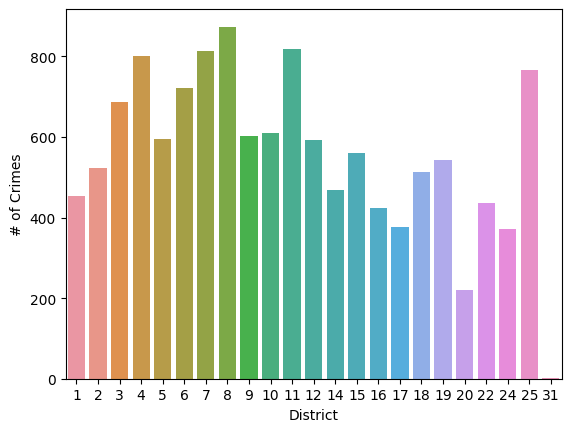

In [87]:
sns.barplot(data=District_crimes, y='# of Crimes', x='District', errorbar=None)


### Which district has the most crimes? Which has the least?
- Looks like district 8 had the most crimes over all and District 31 with the least.